In [ ]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_excel('/content/BST_DataSet.xlsx')

df = df.set_index('Unnamed: 0')

data2017 = df[df.isnull().any(1)]

df.dropna(axis=0, inplace=True)

df['Target Year Rolling Average'] = df['Прирост вкладов физических лиц в рублях (млн руб)'].rolling(12).mean()

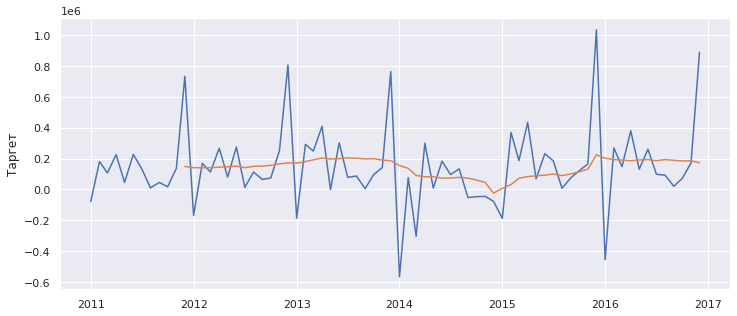

In [ ]:
#График таргета по месяцам и сглаженный предыдущим годом таргет
#для визуализации

plt.figure( figsize = ( 12, 5))
plt.plot(df['Прирост вкладов физических лиц в рублях (млн руб)'])
plt.plot(df['Target Year Rolling Average'])
plt.ylabel('Таргет')
plt.show()

In [ ]:
#Проверка ряда на стационарность

test = sm.tsa.adfuller(df['Прирост вкладов физических лиц в рублях (млн руб)'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -1.5624513827398343
p-value:  0.5024228765613982
Critical values:  {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
Есть единичные корни, ряд не стационарен


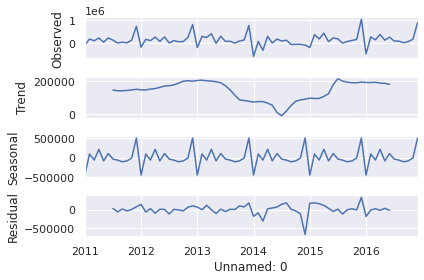

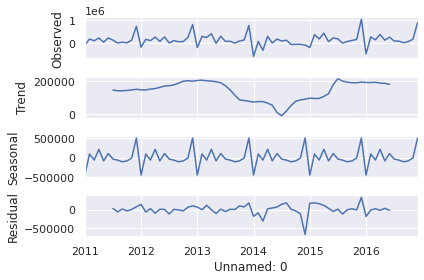

In [ ]:
#Декомпозиция сезонности и тренда, четко видна ежемесячная сезонность, учтем в модели
#(почему он строит два графика не знаю, предположим это фича)

res = sm.tsa.seasonal_decompose(df['Прирост вкладов физических лиц в рублях (млн руб)'], model='additive')
res.plot()

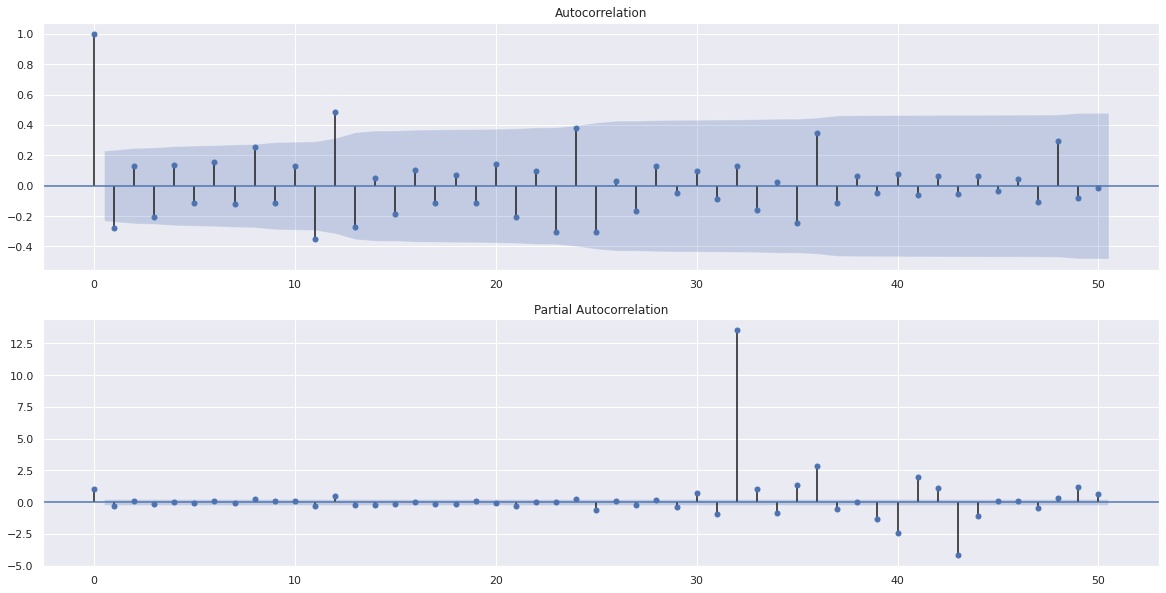

In [ ]:
#Для определения параметров модели строим 
#авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции 
#для ряда первых разностей

fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df['Прирост вкладов физических лиц в рублях (млн руб)'], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['Прирост вкладов физических лиц в рублях (млн руб)'], lags=50, ax=ax[1])
plt.show()

In [ ]:
#d=1, D=1, из коррелограммы ACF q = 1 и Q=0
#из коррелограммы PACF p = 1 b P = 0

model = sm.tsa.statespace.SARIMAX(df['Прирост вкладов физических лиц в рублях (млн руб)'],
                                  order=(1,1,1), seasonal_order=(0,1,0,12)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           Statespace Model Results                                          
=============================================================================================================
Dep. Variable:     Прирост вкладов физических лиц в рублях (млн руб)   No. Observations:                   72
Model:                                SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood                -816.588
Date:                                               Sun, 12 Dec 2021   AIC                           1639.175
Time:                                                       15:56:14   BIC                           1645.408
Sample:                                                   01-01-2011   HQIC                          1641.608
                                                        - 12-01-2016                                         
Covariance Type:                                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1769      0.117      1.507      0.132      -0.053       0.407
ma.L1         -0.9756      0.070    -14.006      0.000      -1.112      -0.839
sigma2      7.576e+10   3.89e-13   1.95e+23      0.000    7.58e+10    7.58e+10
===================================================================================
Ljung-Box (Q):                       42.51   Jarque-Bera (JB):               140.17
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):              10.89   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.63e+39. Standard errors may be unstable.
"""

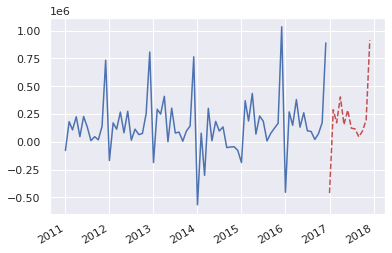

In [ ]:
pred = model.predict('2017-01','2017-12', typ='levels')

plt.plot(df['Прирост вкладов физических лиц в рублях (млн руб)'])
pred.plot(style='r--')